In [1]:
# -*- coding: UTF-8 -*-
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

http://nbviewer.jupyter.org/github/alexminnaar/time-series-classification-and-clustering/blob/master/Time%20Series%20Classification%20and%20Clustering.ipynb

In [2]:
from __future__ import division
import numpy as np
import pandas as pd
import sys
import math
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import re
import os
import csv
from helpers.outliers import MyOutliers
from skroutz_mobile import SkroutzMobile
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
from skroutz_mobile import SkroutzMobile
from sklearn.model_selection import StratifiedShuffleSplit
from helpers.my_train_test_split import MySplitTrainTest
from sklearn.preprocessing import StandardScaler
from preprocess_price_history import PreprocessPriceHistory
from price_history import PriceHistory
from dfa import dfa
import scipy.signal as ss
import nolds
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import random
from sklearn.metrics import silhouette_score
from os.path import isfile
from preprocess_price_history import PreprocessPriceHistory

In [3]:
random_state = np.random.RandomState(seed=16011984)
%matplotlib inline

## Some processing

In [4]:
csv_in = "../price_history_03_seq_start_suddens_trimmed.csv"


In [5]:
df_fixed_width = PreprocessPriceHistory.keepOnlyPriceHistoriesWithMostFrequentLength(csv_in=csv_in)

In [18]:
csv_path = "../price_history_03a_fixed_width.csv"
#df_fixed_width.to_csv(csv_path, encoding='utf-8', quoting=csv.QUOTE_ALL)

# testing

In [19]:
km = KMeans(init='random', #init='k-means++',
            n_clusters=3, n_init=10)
km

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [20]:
km.fit(df_fixed_width.values)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [21]:
km.inertia_

76613685.760995418

In [22]:
km.labels_

array([2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 2, 2, 2, 0, 2, 0, 1, 0, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 0, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 2, 2, 0, 2,
       2, 2], dtype=int32)

### Dynamic Time Wrapping
Dynamic time warping finds the optimal non-linear alignment between two time series.

## K means clustering

https://stackoverflow.com/questions/5529625/is-it-possible-to-specify-your-own-distance-function-using-scikit-learn-k-means

In [23]:
mms = MinMaxScaler()

In [24]:
seqs_norm = mms.fit_transform(seqs_fixed_width.T).T
seqs_norm.shape

(94, 210)

In [25]:
#set random centroids or pseudorandom
#calculate the distance of all points with centroid 1, then the same for centroid 2
#then find a new centroid according to the points you had considered
#then repeat

In [26]:
#kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)

In [27]:
# centroids = random.sample(seqs, 3)
# len(centroids), len(centroids[0]), len(centroids[1]), len(centroids[2])

In [28]:
# aa , _ = fastdtw(seqs[0], seqs[2], dist=euclidean)
# aa

In [29]:
def k_means_clust(data, n_clusters, tol=0.1, n_max_iter=100): #tol=0.0001
    centroids = random.sample(data, n_clusters)
    prev_centroids = centroids[:]
    best_max_diff = float('inf')
    
    data_len = len(data)
    
    labels = np.empty(data_len)
    
    counter = 0
    while counter < n_max_iter:
        counter += 1
        print counter
        
        #we only care about the last inertia but it is minimum cost to calc it on every iter
        cur_inertia = 0
        
        assignments = {}  #dictionary cluster -> data points
        
        for data_ind, xx in enumerate(data):
            min_dist = float('inf')
            closest_clust_ind = None
            
            for c_ind, cc in enumerate(centroids):
                cur_dist, _ = fastdtw(xx, cc, dist=euclidean)
                if cur_dist < min_dist: #this means that current centroid is better
                    closest_clust_ind = c_ind
                    min_dist = cur_dist
                    
            labels[data_ind] = closest_clust_ind
            
            cur_inertia += min_dist
            
            if closest_clust_ind in assignments:
                assignments[closest_clust_ind].append(data_ind)
            else:
                assignments[closest_clust_ind] = [data_ind]
        
        #recalculate centroids of clusters, here we do it in a euclidean way
        #(we do not have reverse dtw)
        for key in assignments:
            cur_assignment_list = assignments[key]
            clust_sum = np.zeros(len(data[0]))
            for kk in cur_assignment_list:
                #print data[kk]
                clust_sum += data[kk]
            
            centroids[key] = clust_sum / len(cur_assignment_list)
        
        diffs = [fastdtw(aa, bb, dist=euclidean)[0] 
                 for aa, bb in zip(prev_centroids, centroids)]
        max_diff = max(diffs)
        
        if max_diff < best_max_diff:
            best_centroids = centroids[:]
            best_inertia = cur_inertia
            best_labels = labels
            best_max_diff = max_diff
        
        print "max diff {}".format(max_diff)
        if max_diff < tol:
            break
        else:
            prev_centroids = centroids[:]
                
    return best_centroids, best_inertia, best_labels

In [30]:
def time_series_kmeans_clust(data, n_clusters, tol=0.1, n_max_iter=100, n_inits = 10):
    best_centroids = None
    best_inertia = float('inf') #the smaller the better
    best_labels = None
    
    for ii in xrange(n_inits):
        print "N INIT {}".format(ii)
        
        centroids, inertia, labels = k_means_clust(
            data=data, n_clusters=n_clusters, tol=tol, n_max_iter=n_max_iter)
        
        if inertia < best_inertia:
            best_centroids = centroids[:]
            best_inertia = inertia
            best_labels = labels
        
        print
            
    return best_centroids, best_inertia, best_labels

In [31]:
dist_matrix = np.load('dist_matrix_fastdtw_94_210_fixed_len.npy')
dist_matrix.shape

(94, 94)

In [32]:
def calc_n_clusters(n_clusters):
    filename = 'ts_kmeans_clust_k_{}.npz'.format(n_clusters)
    if isfile(filename):
        obj = np.load(filename)
        centroids=obj['centroids']
        inertia=obj['inertia']
        labels=obj['labels']
    else:
        
        centroids, inertia, labels = time_series_kmeans_clust(data=seqs_norm, n_clusters=n_clusters,
                                     n_max_iter=100, n_inits=5)
        np.savez(filename,
                 centroids=centroids, inertia=inertia, labels=labels)
    
    silhouette = silhouette_score(dist_matrix, labels=labels, metric="precomputed")
    
    fig = plt.figure(figsize=(15,6))
    for cc in centroids:
        plt.plot(cc)
    plt.show()
    
    return silhouette, inertia

In [35]:
silhouette_scores = dict()

In [33]:
# %%time
# dist_matrix = np.empty(shape=(data_len, data_len))
# for ii in xrange(data_len):
#     for jj in xrange(data_len):
#         dist_matrix[ii, jj] = fastdtw(data[ii], data[jj], dist=euclidean)[0]

In [35]:
n_clusters = 1

2


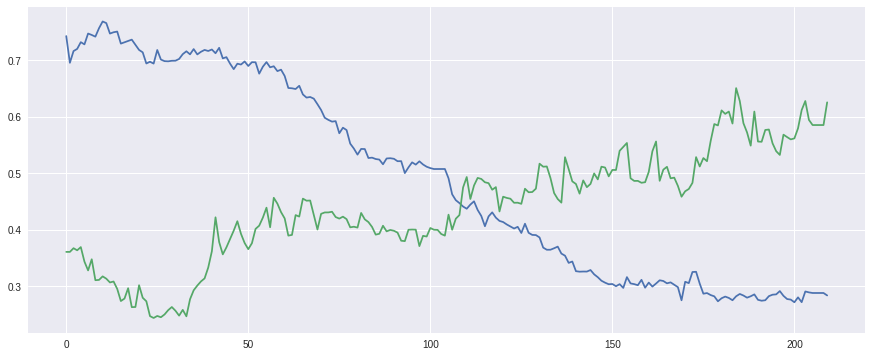

0.364836794412 3184.86553549


In [36]:
n_clusters += 1
print n_clusters
silhouette, inertia = calc_n_clusters(n_clusters = n_clusters)
print silhouette, inertia
silhouette_scores[n_clusters] = silhouette

3


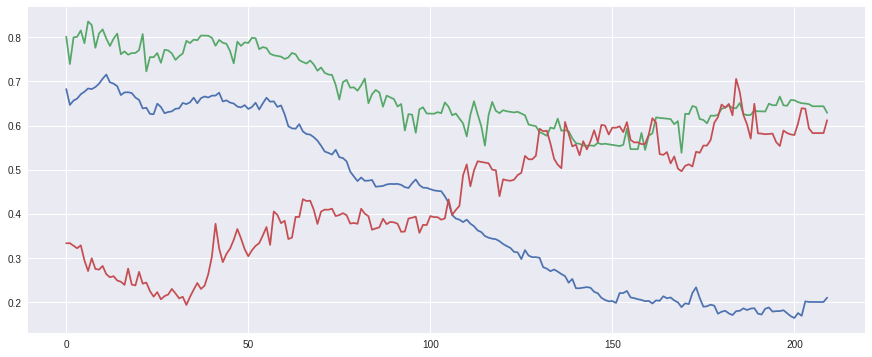

0.346282905256 2611.90134145


In [37]:
n_clusters += 1
print n_clusters
silhouette, inertia = calc_n_clusters(n_clusters = n_clusters)
print silhouette, inertia
silhouette_scores[n_clusters] = silhouette

4


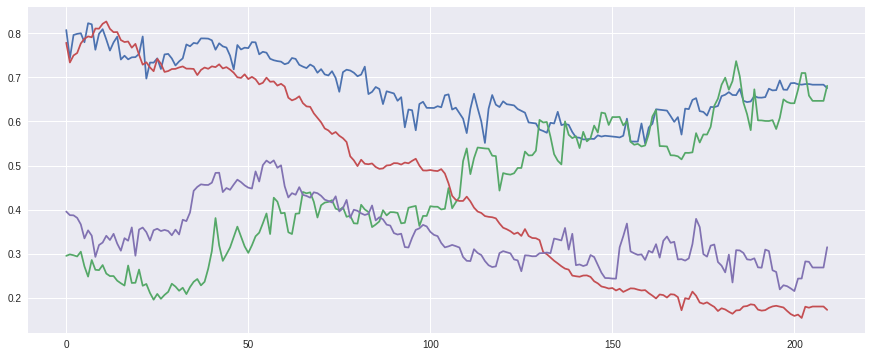

0.308568252108 2368.95367704


In [38]:
n_clusters = 4
print n_clusters
silhouette, inertia = calc_n_clusters(n_clusters = n_clusters)
print silhouette, inertia
silhouette_scores[n_clusters] = silhouette

5


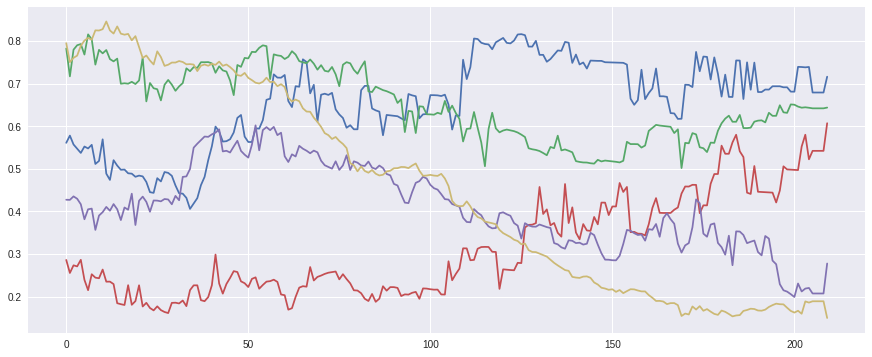

0.246270968418 2187.96750237


In [39]:
n_clusters = 5
print n_clusters
silhouette, inertia = calc_n_clusters(n_clusters = n_clusters)
print silhouette, inertia
silhouette_scores[n_clusters] = silhouette

6 htan 0.23
7 htan 0.24

6


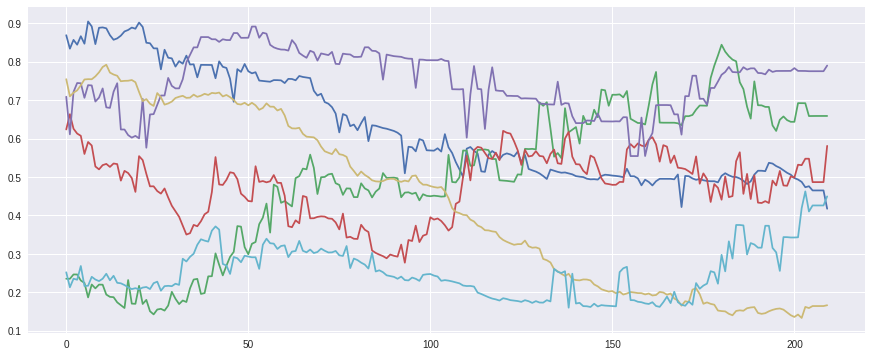

0.241415247676 2068.37375528


In [36]:
n_clusters = 6
print n_clusters
silhouette, inertia = calc_n_clusters(n_clusters = n_clusters)
print silhouette, inertia
silhouette_scores[n_clusters] = silhouette

7
N INIT 0
1
max diff 39.7544251555
2
max diff 14.8849196152
3
max diff 15.8145017419
4
max diff 9.40737248584
5
max diff 8.73189460286
6
max diff 8.69812375262
7
max diff 7.94747416785
8
max diff 7.86723522368
9
max diff 9.34371810442
10
max diff 5.70015739853
11
max diff 8.60584748171
12
max diff 16.1446580107
13
max diff 12.8540360761
14
max diff 13.4446685994
15
max diff 14.2741473472
16
max diff 9.94846235325
17
max diff 8.8435826412
18
max diff 16.6842913047
19
max diff 8.61354796186
20
max diff 11.0939144193
21
max diff 16.648116927
22
max diff 12.7611440656
23
max diff 8.85535837023
24
max diff 7.66548121539
25
max diff 6.31709459435
26
max diff 11.6651519656
27
max diff 8.46615478779
28
max diff 1.55418155277
29
max diff 1.55418155277
30
max diff 1.55418155277
31
max diff 1.55418155277
32
max diff 1.55418155277
33
max diff 1.55418155277
34
max diff 1.55418155277
35
max diff 1.55418155277
36
max diff 1.55418155277
37
max diff 1.55418155277
38
max diff 1.55418155277
39
max diff 

max diff 8.20061429952
61
max diff 6.29539487022
62
max diff 3.66447587253
63
max diff 5.03646019086
64
max diff 6.3058781459
65
max diff 8.20061429952
66
max diff 6.29539487022
67
max diff 3.66447587253
68
max diff 5.03646019086
69
max diff 6.3058781459
70
max diff 8.20061429952
71
max diff 6.29539487022
72
max diff 3.66447587253
73
max diff 5.03646019086
74
max diff 6.3058781459
75
max diff 8.20061429952
76
max diff 6.29539487022
77
max diff 3.66447587253
78
max diff 5.03646019086
79
max diff 6.3058781459
80
max diff 8.20061429952
81
max diff 6.29539487022
82
max diff 3.66447587253
83
max diff 5.03646019086
84
max diff 6.3058781459
85
max diff 8.20061429952
86
max diff 6.29539487022
87
max diff 3.66447587253
88
max diff 5.03646019086
89
max diff 6.3058781459
90
max diff 8.20061429952
91
max diff 6.29539487022
92
max diff 3.66447587253
93
max diff 5.03646019086
94
max diff 6.3058781459
95
max diff 8.20061429952
96
max diff 6.29539487022
97
max diff 3.66447587253
98
max diff 5.03646019

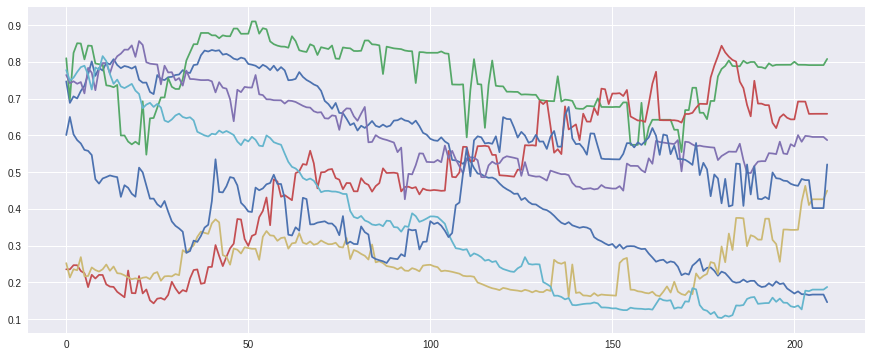

0.212728285197 2020.00197179


In [37]:
n_clusters = 7
print n_clusters
silhouette, inertia = calc_n_clusters(n_clusters = n_clusters)
print silhouette, inertia
silhouette_scores[n_clusters] = silhouette

In [61]:
n_clusters = 8
print n_clusters
silhouette, inertia = calc_n_clusters(n_clusters = n_clusters)
print silhouette, inertia
silhouette_scores[n_clusters] = silhouette

8
N INIT 0
1
max diff 35.6139182393
2
max diff 16.0002590568
3
max diff 14.2745895608
4
max diff 28.3504393014
5
max diff 28.5580305454
6
max diff 10.3271901901
7
max diff 10.2395449604
8
max diff 11.9233483352
9
max diff 9.07686142278
10
max diff 15.0154415727
11
max diff 19.7988319649
12
max diff 17.6911590375
13
max diff 17.8323319811
14
max diff 15.866841604
15
max diff 11.4271508418
16
max diff 16.6280998109

N INIT 1
1
max diff 41.3699553891
2
max diff 12.4736618067
3
max diff 12.5275304409
4
max diff 15.754612946
5
max diff 13.8945347055
6
max diff 11.6626003594
7
max diff 8.53244223431
8
max diff 9.63515759419
9
max diff 10.177047995
10
max diff 12.2220599911
11
max diff 16.0262967557
12
max diff 11.1728777996
13
max diff 10.2648383794
14
max diff 9.52075471811
15
max diff 16.8005664957
16
max diff 32.9824000686

N INIT 2
1
max diff 29.7670002257
2
max diff 18.1857665093
3
max diff 8.77762969739
4
max diff 7.90572852814
5
max diff 11.6242326665
6
max diff 8.43486567179
7
max di

KeyboardInterrupt: 

## Time Series Classification under More Realistic Assumptions
Project URL: http://sites.google.com/site/sdm13realistic/  
Paper URL: http://www.cs.ucr.edu/~eamonn/SDM_RealisticTSClassifcation_cameraReady.pdf

## How to choose the best k in k-means clustering?
Use the Silhouette score:  
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

# Plotting Silhouette Scores

In [4]:
xx = [2, 3, 4, 5, 6, 7]
yy = [0.364836794412,
      0.346282905256,
     0.308568252108,
     0.246270968418,
     0.241415247676,
     0.212728285197]

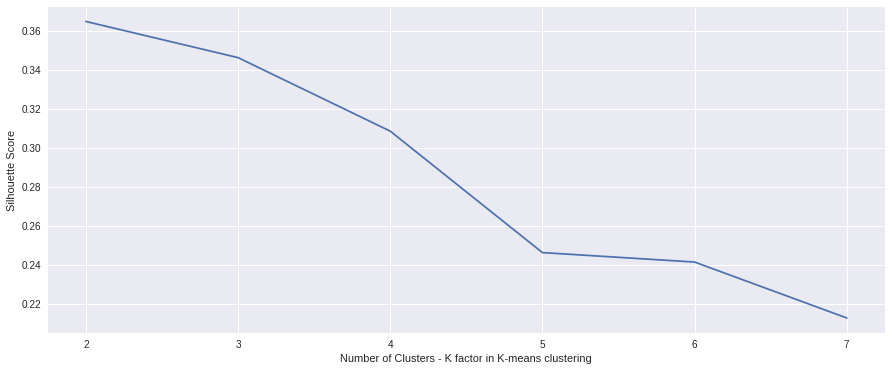

In [5]:
plt.figure(figsize=(15, 6))
plt.plot(xx, yy)
plt.xlabel('Number of Clusters - K factor in K-means clustering')
plt.ylabel('Silhouette Score')
plt.show()